In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
import csv

In [3]:
import myKit

In [4]:
import pandas as pd

In [5]:
import numpy as np
from PIL import Image, ImageOps


In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [7]:
d2l.set_figsize()
img = Image.open('../data/archive/boneage-training-dataset/1377.png')
# d2l.plt.imshow(img)
type(img)

PIL.PngImagePlugin.PngImageFile

In [8]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    print(type(Y))
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

In [9]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))

<class 'list'>


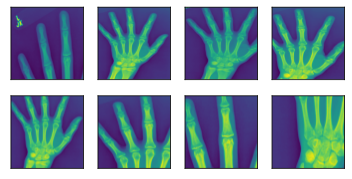

In [10]:
apply(img, shape_aug)

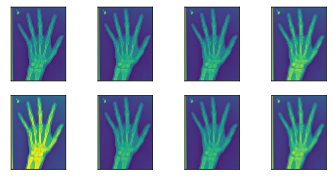

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

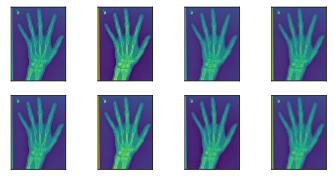

In [ ]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In [ ]:
from albumentations.augmentations.transforms import Lambda, RandomBrightnessContrast
from albumentations.augmentations.geometric.transforms import ShiftScaleRotate, HorizontalFlip
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.crops.transforms import RandomResizedCrop
from albumentations import Compose
from torchvision import transforms
import cv2

In [ ]:
def sample_normalize(image, **kwargs):
    """标准化每个通道"""
    image = image // 255
    channel = image.shape[2]
    mean, std = image.reshape((-1, channel)).mean(axis=0), image.reshape((-1, channel)).std(axis=0)
    return (image - mean) / (std + 1e-3)

# 随机删除一个图片上的像素，p为执行概率，scale擦除部分占据图片比例的范围，ratio擦除部分的长宽比范围
randomErasing = transforms.RandomErasing(scale=(0.02, 0.08), ratio=(0.5, 2), p=0.8)


def randomErase(image, **kwargs):
    """随机删除一个图片上的像素"""
    return randomErasing(image)

In [ ]:
transform_train = Compose([
    # 随机大小裁剪，512为调整后的图片大小，（0.5,1.0）为scale剪切的占比范围，概率p为0.5
    RandomResizedCrop(512, 512, (0.5, 1.0), p=0.5),
    # ShiftScaleRotate操作：仿射变换，shift为平移，scale为缩放比率，rotate为旋转角度范围，border_mode用于外推法的标记，value即为padding_value，前者用到的，p为概率
    ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, value=0.0,
                     p=0.8),
    # 水平翻转
    HorizontalFlip(p=0.5),
    # 概率调整图片的对比度
    RandomBrightnessContrast(p=0.8, contrast_limit=(-0.3, 0.2)),
    # 标准化
    Lambda(image=sample_normalize),
    # 将图片转化为tensor类型
    ToTensorV2(),
    # 做随机擦除
    Lambda(image=randomErase)
])

In [ ]:
def read_image(data_dir, fname, image_size=512):
    """读取图片，并统一修改为512x512"""
    img = Image.open(os.path.join(data_dir, fname))
    # 开始修改尺寸
    w, h = img.size
    long = max(w, h)
    # 按比例缩放成512
    w, h = int(w / long * image_size), int(h / long * image_size)
    # 压缩并插值
    img = img.resize((w, h), Image.ANTIALIAS)
    # 然后是给短边扩充，使用ImageOps.expand
    delta_w, delta_h = image_size - w, image_size - h
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    # 转化成np.array，并通过compose输出，输出格式为(3, 512, 512)
    # img = ImageOps.expand(img, padding).convert("RGB")
    # return img
    img = transform_train(image=np.array(ImageOps.expand(img, padding).convert("RGB")))['image']
    return torch.reshape(img, (1, 3, 512, 512))


In [ ]:
Id, age, gender = myKit.read_labels('./dataset/', 'boneage-training-dataset.csv')

In [ ]:
# new_img = read_image(data_dir='./dataset/boneage-training-dataset/', fname='10245.png')
# # new_img = myKit.transform_train(image= new_img)
# # d2l.plt.imshow(new_img)
# # type(new_img)
# new_img = new_img.squeeze()
# this_pic = transforms.ToPILImage()(new_img)
# this_pic

In [ ]:
aug_dataset = Compose([
    # 随机大小裁剪，512为调整后的图片大小，（0.5,1.0）为scale剪切的占比范围，概率p为0.5
    RandomResizedCrop(512, 512, (0.5, 1.0), p=0.5),
    # ShiftScaleRotate操作：仿射变换，shift为平移，scale为缩放比率，rotate为旋转角度范围，border_mode用于外推法的标记，value即为padding_value，前者用到的，p为概率
    ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, value=0.0,
                     p=0.8),
    # 水平翻转
    HorizontalFlip(p=0.5),
    # 概率调整图片的对比度
    RandomBrightnessContrast(p=0.8, contrast_limit=(-0.3, 0.2)),
    # 将图片转化为tensor类型
    ToTensorV2(),
])

In [ ]:
def read_a_image(data_dir, fname, image_size=512):
    """读取图片，并统一修改为512x512"""
    img = Image.open(os.path.join(data_dir, fname))
    # 开始修改尺寸
    w, h = img.size
    long = max(w, h)
    # 按比例缩放成512
    w, h = int(w / long * image_size), int(h / long * image_size)
    # 压缩并插值
    img = img.resize((w, h), Image.ANTIALIAS)
    # 然后是给短边扩充，使用ImageOps.expand
    delta_w, delta_h = image_size - w, image_size - h
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    # 转化成np.array，并通过compose输出，输出格式为(3, 512, 512)
    # img = ImageOps.expand(img, padding).convert("RGB")
    # return img
    # img = aug_dataset(image=np.array(ImageOps.expand(img, padding).convert("RGB")))['image']
    img = np.array(ImageOps.expand(img, padding).convert("RGB"))
    return img

In [ ]:
def save_one_augpic(data_dir, fname, label, aug_idx, aug):
    img = read_a_image(data_dir=data_dir, fname=fname)
    img = aug(image=img)['image']
    img = transforms.ToPILImage()(img)
    id = fname.split('.')[0]+aug_idx
    age = label[0]
    male = label[1]
    row = [id, age, male]
    save_path = f'{data_dir}/{id}.png'
    img.save(save_path)
    with open('./dataset/small-dataset.csv', 'a+', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(row)

# aug_one_pic(data_dir='./dataset/small-dataset/1/', fname='3806.png', label=['1', 'False'], aug_idx='01')

In [ ]:
def read_csv_labels_noMale(fname):
    """Read `fname` to return a filename to label dictionary.

    Defined in :numref:`sec_kaggle_cifar10`"""
    with open(fname, 'r') as f:
        # Skip the file header line (column name) 跳过文件头
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    # return dict(((id, boneage) for id, boneage, male in tokens))
    return dict((id, [boneage, male]) for id, boneage, male in tokens)

In [ ]:
def apply(input_root, aug, aug_size, label_list):
    """对文件夹下的所有图片进行增广"""
    for root, dirs, files in os.walk(input_root):
        dirs_size = len(dirs)
        files_size = len(files)
        if(dirs_size == 0 and files_size < aug_size):
            need_size = aug_size - files_size
            files = sorted(files)
            for i in range(need_size):
                new_id = '0'+str(i)
                idx = i%files_size
                fname = files[idx]
                label = label_list[fname.split('.')[0]]
                save_one_augpic(data_dir=root, fname=fname, label=label, aug_idx=new_id, aug=aug)
                
        # print(f'root:{root}, dirs:{dirs}, files:{files}')
    # Y = [aug(img) for _ in range(num_rows * num_cols)]
    # d2l.show_images(Y, num_rows, num_cols, scale=scale)
labels = read_csv_labels_noMale(os.path.join('./dataset/', 'small-dataset.csv'))
apply('./dataset/small-dataset/', aug_dataset, 10, labels)